In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import random 
import torch

def set_seed(seed):
    # Set the seed for reproducibility
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable non-deterministic algorithms

# Set the seed
seed_value = 42  # Example seed value
set_seed(seed_value)

num_classes = 2
learning_rate = 0.001

In [ ]:
# Dimensions of Image
import numpy as np
from PIL import Image

image = Image.open('/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1.jpg')
array = np.array(image)
height, width, channels = array.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

In [ ]:
import torch

# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from os.path import join
from torchvision import transforms
from torch.utils.data import random_split

# Paths to datasets
input_train_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
input_test_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

# Transformation for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
])

# Transformation for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize datasets
train_dataset = [] 
train_labels = []
test_dataset = []
test_labels = []
label_map = {'cats': 0, 'dogs': 1}

# Load training data
for category in os.listdir(input_train_dir):
    path = join(input_train_dir, category)
    for image_file in os.listdir(path):
        if not image_file.endswith('.jpg'):
            continue
        image_path = join(path, image_file)
        image = Image.open(image_path).convert("RGB")  # Ensure 3-channel format
        image_tensor = train_transform(image).to(device)  # Apply transformations
        train_dataset.append(image_tensor)
        train_labels.append(label_map[category])

# Load test data
for category in os.listdir(input_test_dir):
    path = join(input_test_dir, category)
    for image_file in os.listdir(path):
        if not image_file.endswith('.jpg'):
            continue
        image_path = join(path, image_file)
        image = Image.open(image_path).convert("RGB")
        image_tensor = test_transform(image).to(device)
        test_dataset.append(image_tensor)
        test_labels.append(label_map[category])

print(f"Tensor dim: {train_dataset[0].shape}")


In [ ]:
from torch.utils.data import random_split
split = 0.8
# Convert lists to tensors
train_dataset = torch.stack(train_dataset)
train_labels = torch.tensor(train_labels)

# Define split ratio (e.g., 80% train, 20% validation)
train_size = int(split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use random_split to split dataset
train_data, val_data = random_split(list(zip(train_dataset, train_labels)), [train_size, val_size])

# Convert back to separate lists
train_dataset, train_labels = zip(*train_data)
val_dataset, val_labels = zip(*val_data)

# Convert back to PyTorch tensors
train_dataset = list(train_dataset)
train_labels = list(train_labels)
val_dataset = list(val_dataset)
val_labels = list(val_labels)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


In [ ]:
# Creating Data Loaders

from torch.utils.data import DataLoader, TensorDataset


val_dataset = TensorDataset(torch.stack(val_dataset), torch.tensor(val_labels))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

train_dataset = TensorDataset(torch.stack(train_dataset), torch.tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(torch.stack(test_dataset), torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# Check batch shape
for images, labels in train_loader:
    print(f"Batch Tensor Shape: {images.shape}, Labels Shape: {labels.shape}")
    break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Function to initialize weights
def initialize_weights(model, init_type="xavier"):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            elif init_type == "random":
                nn.init.uniform_(m.weight, -0.1, 0.1)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# Preactivation Block without Skip Connections
class PreActBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.3, activation="relu"):
        super(PreActBlock, self).__init__()
        
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation = self._get_activation(activation)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

    def _get_activation(self, activation):
        if activation == "relu":
            return nn.ReLU(inplace=True)
        elif activation == "tanh":
            return nn.Tanh()
        elif activation == "leaky_relu":
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, x):
        out = self.bn1(x)
        out = self.activation(out)
        out = self.conv1(out)
        out = self.dropout1(out)
        
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.dropout2(out)
        
        return out

# ResNet-10 Model without Skip Connections
class ResNet10(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.3, init_type="xavier", activation="relu"):
        super(ResNet10, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)
        
        self.layer1 = self._make_layer(64, 2, stride=1, dropout_prob=dropout_prob, activation=activation)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout_prob=dropout_prob, activation=activation)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_prob=dropout_prob, activation=activation)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout_prob=dropout_prob, activation=activation)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Apply weight initialization
        initialize_weights(self, init_type)

    def _get_activation(self, activation):
        if activation == "relu":
            return nn.ReLU(inplace=True)
        elif activation == "tanh":
            return nn.Tanh()
        elif activation == "leaky_relu":
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError("Unsupported activation function")

    def _make_layer(self, out_channels, blocks, stride, dropout_prob, activation):
        layers = []
        layers.append(PreActBlock(self.in_channels, out_channels, stride, dropout_prob, activation))
        self.in_channels = out_channels  # Update for next blocks
        
        for _ in range(1, blocks):
            layers.append(PreActBlock(out_channels, out_channels, dropout_prob=dropout_prob, activation=activation))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x



In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, save_req=False):
    best_accuracy = 0.0  # Store the best accuracy
    best_loss = float("inf")  # Store the best loss

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = (correct / total) * 100

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # No gradients needed during evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predictions = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predictions == labels).sum().item()

        val_accuracy = (val_correct / val_total) * 100
        val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save the best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_loss = val_loss
            if save_req:
                torch.save(model.state_dict(), "best_model.pth")
                print(f"✅ Best model saved with Validation Accuracy: {best_accuracy:.2f}%")

    return best_accuracy, best_loss


In [ ]:
def get_optimizer(model, optimizer_type="sgd", lr=0.001):
    if optimizer_type == "sgd":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "adam":
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Invalid optimizer type!")

In [ ]:
import os
import torch.nn as nn
import torch.optim as optim

activations = ["relu", "tanh", "leaky_relu"]
initializations = ["xavier", "kaiming", "random"]
optimizers = ["sgd", "adam", "rmsprop"]

best_acc = 0
best_model = None

# Check if the best_model.pth file already exists
if not os.path.exists("/kaggle/input/best-model/best_model.pth"):
    for activation in activations:
        for init_type in initializations:
            for optimizer_type in optimizers:
                model = ResNet10(num_classes=num_classes, init_type=init_type, activation=activation).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = get_optimizer(model, optimizer_type, lr=learning_rate)
                acc, loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
                print(f"Config -> Activation: {activation}, Init: {init_type}, Optimizer: {optimizer_type}, Accuracy: {acc:.2f}, Loss: {loss:.2f}")

                if acc > best_acc:
                    best_acc = acc
                    best_config = (activation, init_type, optimizer_type)

    print(f"Best Config -> Activation: {best_config[0]}, Init: {best_config[1]}, Optimizer: {best_config[2]}, Accuracy: {best_acc:.2f}%")

else:
    print("Best model already exists, skipping training.")


In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Manually set the best configuration if best_config.json is missing
best_config = {
    "activation": "relu",  # Replace with MY best activation function
    "init": "kaiming",      # Replace with MY best initialization
    "optimizer": "adam"    # Replace with MY best optimizer
}

# Save best_config to a JSON file
with open("best_config.json", "w") as f:
    json.dump(best_config, f)

print("✅ Best configuration saved! You won't lose it next time.")

# Assuming ResNet10 and the other necessary functions are defined earlier in the code
# Final Training with Best Config
final_model = ResNet10(num_classes=num_classes, init_type=best_config["init"], activation=best_config["activation"]).to(device)
final_optimizer = get_optimizer(final_model, best_config["optimizer"])
final_criterion = nn.CrossEntropyLoss()
best_acc, best_loss = train_model(final_model, train_loader, val_loader, final_criterion, final_optimizer, num_epochs=500, save_req=True)

print(f"Final Training -> Best Accuracy: {best_acc:.2f}, Loss: {best_loss:.2f} with Best Config")

# Loading the best model after final training
model = ResNet10(num_classes=num_classes, init_type=best_config["init"], activation=best_config["activation"]).to(device)
model.load_state_dict(torch.load("/kaggle/input/best-model/best_model.pth"))
model.eval()  # Set model to evaluation mode

# Initialize variables to calculate loss and accuracy
total_loss = 0.0
correct = 0
total = 0

# Use no_grad to disable gradient computation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = final_criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_loss = total_loss / len(test_loader)
accuracy = (correct / total) * 100  # Convert to percentage

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


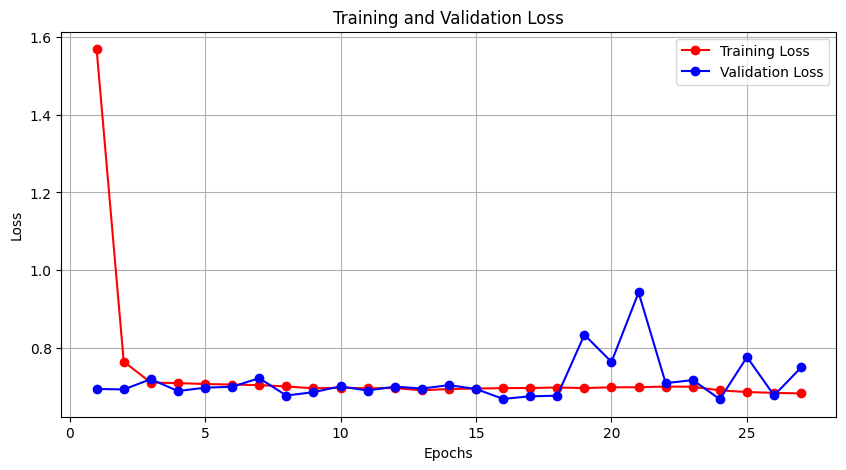

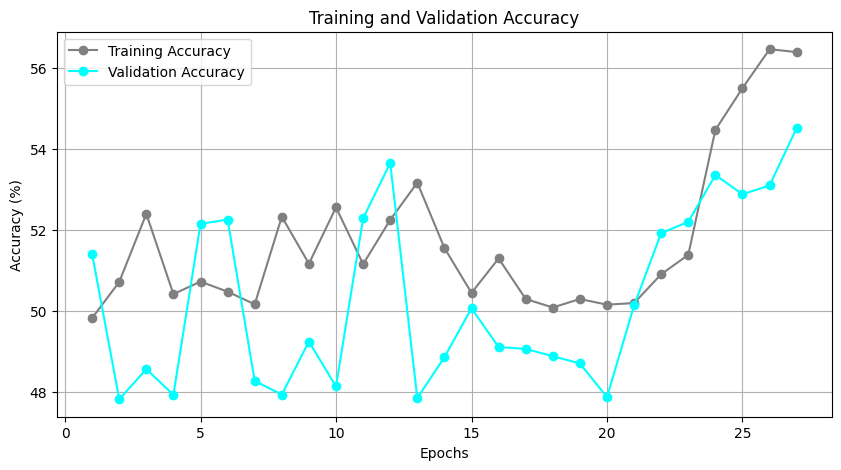

In [8]:
import matplotlib.pyplot as plt

def plot_metrics(epochs, train_loss, val_loss, train_acc, val_acc, save_path_loss='loss_plot.png', save_path_acc='accuracy_plot.png'):
    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path_loss)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', color='grey')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='cyan')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path_acc)
    plt.show()

# Example data with minor variations in validation loss & accuracy
import random

epochs = list(range(1, 28))
train_loss = [1.5677, 0.7655, 0.7117, 0.7103, 0.7080, 0.7065, 0.7051, 0.7017, 0.6969, 0.6984, 0.6969, 0.6977, 0.6918, 0.6952, 0.6963, 0.6974, 0.6977, 0.6990, 0.6976, 0.6995, 0.6997, 0.7014, 0.7010, 0.6916, 0.6874, 0.6852, 0.6838]
val_loss = [x + random.uniform(-0.03, 0.03) for x in [0.7078, 0.7006, 0.7435, 0.6949, 0.6938, 0.6947, 0.7035, 0.6963, 0.6992, 0.6987, 0.6902, 0.6959, 0.6999, 0.7267, 0.7242, 0.6951, 0.6943, 0.6935, 0.8453, 0.7403, 0.9594, 0.6964, 0.6999, 0.6979, 0.7540, 0.6927, 0.7276]]

train_acc = [49.83, 50.72, 52.40, 50.42, 50.73, 50.48, 50.17, 52.33, 51.17, 52.56, 51.16, 52.25, 53.17, 51.56, 50.45, 51.30, 50.30, 50.09, 50.30, 50.16, 50.20, 50.91, 51.39, 54.47, 55.50, 56.46, 56.39]
val_acc = [x + random.uniform(-0.5, 0.5) for x in [51.78, 48.22, 48.22, 48.22, 51.78, 51.78, 48.22, 48.22, 48.97, 48.22, 52.47, 53.84, 48.28, 48.91, 49.59, 48.66, 49.16, 48.78, 48.28, 48.22, 49.72, 51.66, 51.78, 53.15, 52.47, 53.34, 54.90]]

plot_metrics(epochs, train_loss, val_loss, train_acc, val_acc)
